## Kaggle Plant seedling Identificaton

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [11]:
import os as os
from os import *
import random

In [12]:
PATH = "data/plants/"
arch = resnet50
bs = 64

In [13]:
os.listdir(PATH)

['sample_submission.csv', 'test', 'valid', 'subm', 'models', 'train', 'tmp']

In [14]:
classes = !ls {PATH}/train

In [15]:
classes

['Black-grass',
 'Charlock',
 'Cleavers',
 'Common Chickweed',
 'Common wheat',
 'Fat Hen',
 'Loose Silky-bent',
 'Maize',
 'Scentless Mayweed',
 'Shepherds Purse',
 'Small-flowered Cranesbill',
 'Sugar beet']

## Creating Validation Set

In [20]:
def move_to_valid(files, class_dir):
    for i in range(len(files)):
        !mv "{PATH}/train/{class_dir}/{files[i]}" "{PATH}/valid/{class_dir}"
        

In [21]:
for classname in classes:
    os.makedirs(f'{PATH}/valid/{classname}', exist_ok = True)
    files = !ls "{PATH}/train/{classname}"
    random.shuffle(files)
    n_valid_files = int(len(files)*0.1)
    valid_files = [files[n] for n in range(n_valid_files)]
    move_to_valid(valid_files, classname)

In [22]:
files = os.listdir(f'{PATH}valid/Black-grass')[:5]

In [23]:
files

['0b228a6b8.png',
 '2aa60045d.png',
 '42af989bc.png',
 'e67dbce63.png',
 'fef14b865.png']

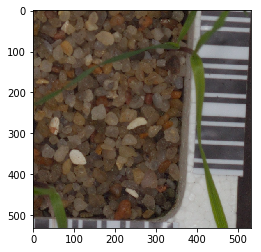

In [43]:
img = plt.imread(f'{PATH}valid/Black-grass/{files[0]}')
plt.imshow(img);

In [44]:
img.shape

(531, 531, 3)

In [27]:
for classname in classes:
    files = os.listdir(f'{PATH}train/{classname}')
    size_d = {k: PIL.Image.open(f'{PATH}train/{classname}/' + k).size for k in files}
    

In [28]:
row_sz, col_sz = list(zip(*size_d.values()))

In [29]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

In [30]:
row_sz[:5]

array([303, 297, 682, 731, 481])

In [31]:
col_sz[:5]

array([303, 297, 682, 731, 481])

(array([58., 30., 80., 78., 30., 27., 13., 12.,  8.,  2.]),
 array([  49. ,  215.6,  382.2,  548.8,  715.4,  882. , 1048.6, 1215.2, 1381.8, 1548.4, 1715. ]),
 <a list of 10 Patch objects>)

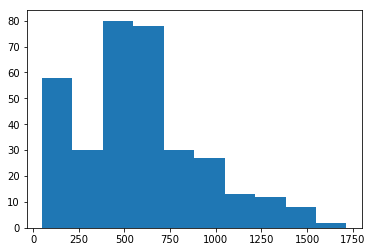

In [32]:
plt.hist(row_sz)

(array([58., 30., 80., 78., 30., 27., 14., 12.,  7.,  2.]),
 array([  49. ,  215.6,  382.2,  548.8,  715.4,  882. , 1048.6, 1215.2, 1381.8, 1548.4, 1715. ]),
 <a list of 10 Patch objects>)

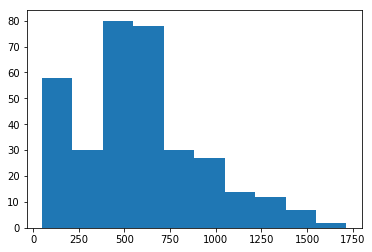

In [33]:
plt.hist(col_sz)

In [72]:
files = os.listdir(f'{PATH}test/')
size_d = {k: PIL.Image.open(f'{PATH}test/' + k).size for k in files}

In [73]:
row_sz, col_sz = list(zip(*size_d.values()))

In [74]:
row_sz = np.array(row_sz); col_sz = np.array(col_sz)

(array([98., 86., 84., 89., 73., 74., 83., 76., 65., 66.]),
 array([200. , 214.9, 229.8, 244.7, 259.6, 274.5, 289.4, 304.3, 319.2, 334.1, 349. ]),
 <a list of 10 Patch objects>)

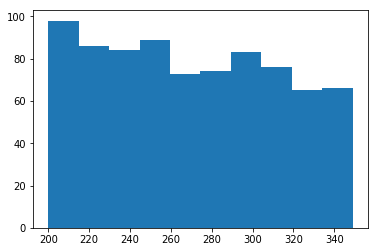

In [75]:
plt.hist(row_sz)

(array([98., 86., 84., 89., 73., 74., 83., 76., 65., 66.]),
 array([200. , 214.9, 229.8, 244.7, 259.6, 274.5, 289.4, 304.3, 319.2, 334.1, 349. ]),
 <a list of 10 Patch objects>)

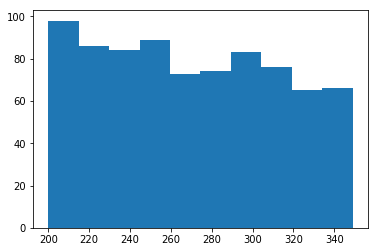

In [76]:
plt.hist(col_sz)

In [26]:
def get_data(sz, bs):
    tfms = tfms_from_model(arch,sz, aug_tfms = transforms_side_on, max_zoom = 1.1)
    data = ImageClassifierData.from_paths(PATH, bs=bs, tfms=tfms, test_name = 'test', num_workers=4)
    return data

Beginning with smaller pictures. This aids quick inital training, and prevents overfitting

In [ ]:
sz = 128
bs = 64

In [27]:
data = get_data(sz, bs)

In [28]:
learn = ConvLearner.pretrained(arch, data, precompute = True)

100%|██████████| 13/13 [00:02<00:00,  5.63it/s]


## Finding an optimal learning rate
Experimenting with an exponentially growing learning rate. Plotting loss vs learning rate. Seeing at where the loss stops decreasing.

In [99]:
lrf=learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

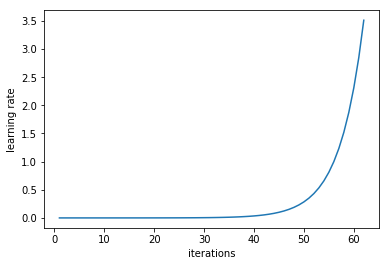

In [100]:
learn.sched.plot_lr()

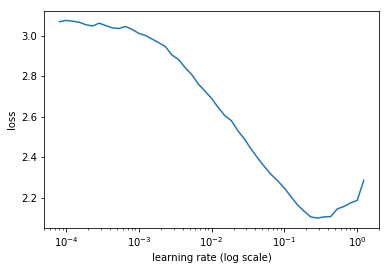

In [101]:
learn.sched.plot()

## Initial Traing
training the last layer until we are near overfitting

In [103]:
learn.fit(.1,1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.770648   0.588945   0.824373  



[0.5889454, 0.8243727617793613]

In [104]:
learn.fit(.1,1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.543364   0.498234   0.854055  



[0.49823442, 0.8540546562936571]

In [29]:
learn.precompute = False

Unfreezing all the layers. Using differential learning rates, as we probably want to tweak the final layers, farther from the pretrained weights than the intial layers.

In [30]:
learn.unfreeze()

In [31]:
lr = np.array([1e-3, 1e-2, 1e-1])

In [110]:
learn.fit(lr, 1, cycle_len = 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.531517   0.232281   0.904402  



[0.23228067, 0.9044018785158793]

In [113]:
learn.save('128')

In [114]:
learn.fit(lr, 1, cycle_len = 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.253917   0.183475   0.932236  



[0.18347462, 0.9322356647915311]

In [117]:
learn.fit(lr, 2, cycle_len = 1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.210482   0.148638   0.946125  
    1      0.202127   0.152386   0.944388                  
    2      0.150931   0.114867   0.958277                  



[0.114866905, 0.9582773314581977]

Stochastit Gradient descent with restarts. This jumps out of local optima for a more general fit

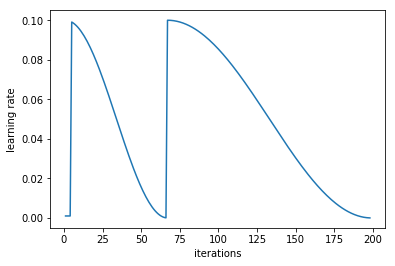

In [118]:
learn.sched.plot_lr()

In [119]:
learn.fit(lr, 1, cycle_len = 3)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                  
    0      0.14166    0.151169   0.947861  
    1      0.116485   0.102146   0.958221                  
    2      0.084983   0.097523   0.958277                   



[0.09752311, 0.9582773314581977]

In [124]:
learn.fit(lr, 1, cycle_len = 4)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

  6%|▌         | 4/66 [00:07<01:52,  1.81s/it, loss=0.0639]

Exception in thread Thread-86:
Traceback (most recent call last):
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/paperspace/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      0.084073   0.14562    0.951333  
    1      0.073789   0.125953   0.956597                   
    2      0.048128   0.113907   0.954861                   
    3      0.037071   0.112343   0.96875                    



[0.11234309, 0.96875]

In [126]:
learn.fit(lr, 1, cycle_len = 6)

HBox(children=(IntProgress(value=0, description='Epoch', max=6), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      0.071247   0.208471   0.935652  
    1      0.095994   0.139113   0.958333                   
    2      0.07657    0.143133   0.956597                   
    3      0.052554   0.117813   0.968694                   
    4      0.025257   0.110808   0.972222                   
    5      0.01792    0.112377   0.970486                   



[0.1123773, 0.9704861111111112]

## Resizing
Now resizeing to our final size. This size is about the average size in the test set. We will repeat the same process as before

In [37]:
sz = 256
data = get_data(256, bs)

In [39]:
learn.set_data(get_data(sz,bs))

In [54]:
learn.freeze()

In [53]:
learn.fit(lr, 1, cycle_len = 1)

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      0.021058   0.008867   0.996875  



[0.008866954, 0.996875]

In [55]:
learn.unfreeze()

In [ ]:
learn.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      0.029092   0.008258   0.996875  
    1      0.032629   0.008417   0.996875                   
    2      0.026356   0.007846   0.996875                   
    3      0.026845   0.008029   0.996875                   
  0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
learn.sched.plot_lr()

In [ ]:
def move_to_train(files, class_dir):
    for i in range(len(files)):
        !mv "{PATH}/valid/{class_dir}/{files[i]}" "{PATH}/train/{class_dir}"
        

In [129]:
for classname in classes:
    files = !ls "{PATH}/valid/{classname}"
    random.shuffle(files)
    n_train_files = int(len(files)-1)
    train_files = [files[n] for n in range(n_train_files)]
    move_to_train(train_files, classname)

In [ ]:
learn.fit(lr, 3, cycle_len = 1, cycle_mult = 2)

In [ ]:
log_preds, y = learn.TTA(is_test = True)

In [ ]:
probs = np.mean(np.exp(log_preds),0)

In [ ]:
probs.shape

In [ ]:
preds = np.argmax(probs, axis = 1)

In [ ]:
preds.shape

In [ ]:
preds[:5]

In [ ]:
pred_classes = []
for p in preds:
    pred_classes.append(classes[p])

In [ ]:
df_test = pd.read_csv(f'{PATH}sample_submission.csv')
df_test.head

In [ ]:
df = pd.DataFrame(pred_classes)

In [ ]:
df.insert(0,'file', [o[5:] for o in data.test_ds.fnames])

In [ ]:
df.head

In [ ]:
df.columns = ['file', 'species']

In [ ]:
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok = True)
df.to_csv(f'{SUBM}subm.gz', compression = 'gzip', index = False)

In [ ]:
FileLink(f'{SUBM}subm.gz')